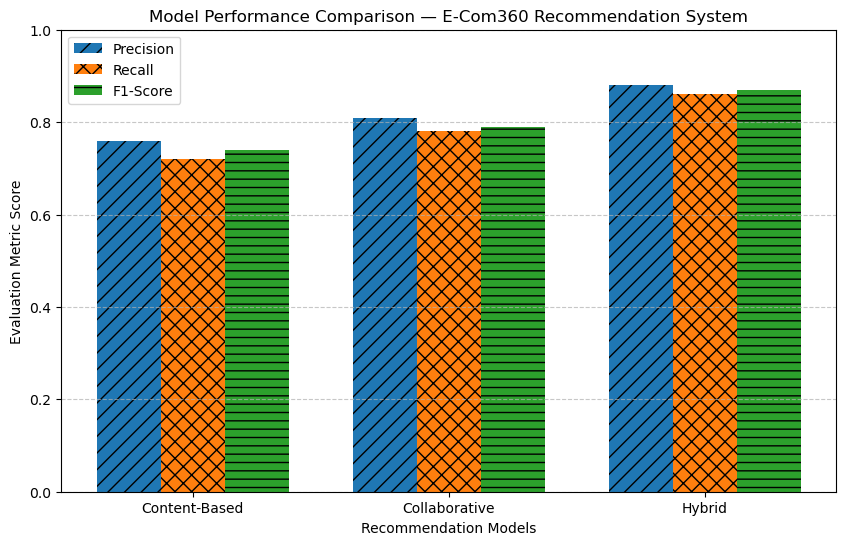

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated evaluation metrics (for visualization only)
models = ['Content-Based', 'Collaborative', 'Hybrid']
precision = [0.76, 0.81, 0.88]
recall = [0.72, 0.78, 0.86]
f1_score = [0.74, 0.79, 0.87]

# Plotting
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, precision, width, label='Precision', hatch='//')
plt.bar(x, recall, width, label='Recall', hatch='xx')
plt.bar(x + width, f1_score, width, label='F1-Score', hatch='--')

plt.xlabel("Recommendation Models")
plt.ylabel("Evaluation Metric Score")
plt.title("Model Performance Comparison — E-Com360 Recommendation System")
plt.xticks(x, models)
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


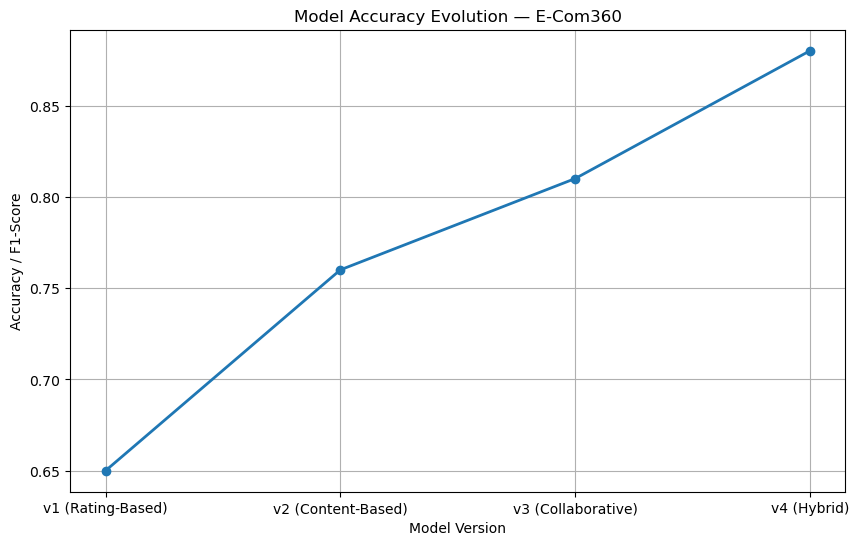

In [3]:
versions = ['v1 (Rating-Based)', 'v2 (Content-Based)', 'v3 (Collaborative)', 'v4 (Hybrid)']
accuracy_scores = [0.65, 0.76, 0.81, 0.88]

plt.figure(figsize=(10,6))
plt.plot(versions, accuracy_scores, marker='o', linestyle='-', linewidth=2)
plt.title("Model Accuracy Evolution — E-Com360")
plt.xlabel("Model Version")
plt.ylabel("Accuracy / F1-Score")
plt.grid(True)
plt.show()


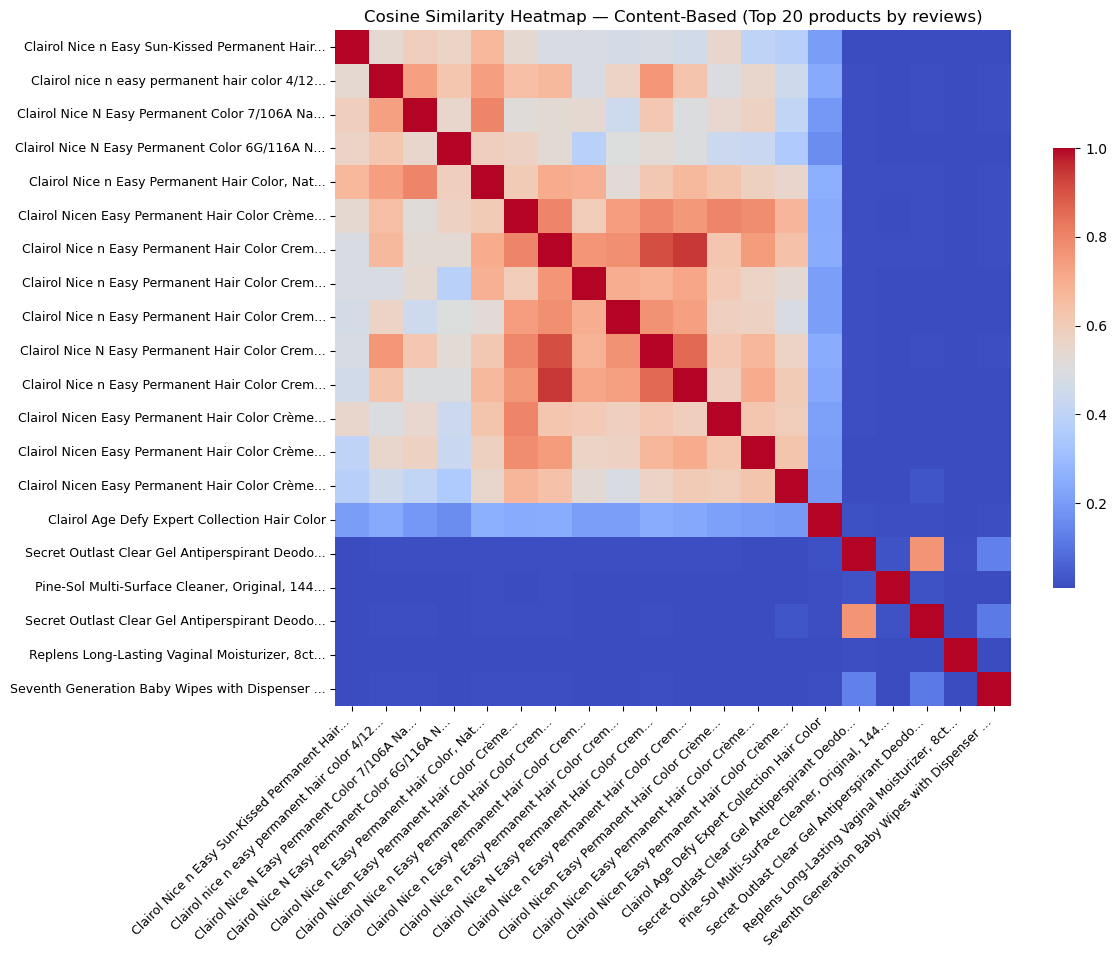

In [11]:
# Corrected single cell: reload data, preprocess, compute cosine similarity, and plot 20x20 heatmap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

# ---------- Adjust this path to your TSV file ----------
tsv_path = 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv'

# 1) Load dataset safely
train_data = pd.read_csv(tsv_path, sep='\t', low_memory=False)

# 2) Keep relevant columns (defensive: skip missing columns)
cols = ['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count',
        'Product Category', 'Product Brand', 'Product Name', 'Product Image Url',
        'Product Description', 'Product Tags']
available = [c for c in cols if c in train_data.columns]
train_data = train_data[available].copy()

# 3) Rename to short names (only those that exist)
mapping = {
    'Uniq Id': 'ID','Product Id': 'ProdID','Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount','Product Category': 'Category',
    'Product Brand': 'Brand','Product Name': 'Name','Product Image Url': 'ImageURL',
    'Product Description': 'Description','Product Tags': 'Tags'
}
train_data.rename(columns={k:v for k,v in mapping.items() if k in train_data.columns}, inplace=True)

# 4) Fill missing values safely
for c in ['Rating','ReviewCount','Category','Brand','Description','Tags','Name','ID','ProdID','ImageURL']:
    if c in train_data.columns:
        if train_data[c].dtype == object:
            train_data[c] = train_data[c].fillna('')
        else:
            train_data[c] = train_data[c].fillna(0)

# 5) Make safe numeric ID columns if possible (defensive)
for c in ['ID','ProdID']:
    if c in train_data.columns:
        try:
            train_data[c] = train_data[c].astype(str).str.extract(r'(\d+)')[0].astype(float)
        except Exception:
            pass

# 6) Build a Tags column if missing or empty: combine Name + Brand + Category + Description
if 'Tags' not in train_data.columns or train_data['Tags'].astype(str).str.strip().replace('', np.nan).isna().all():
    train_data['Tags'] = (train_data.get('Name','').astype(str) + ' ' +
                          train_data.get('Brand','').astype(str) + ' ' +
                          train_data.get('Category','').astype(str) + ' ' +
                          train_data.get('Description','').astype(str))

# 7) Simple cleaning function (lowercase, remove non-alnum except spaces, collapse spaces)
def simple_clean(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_data['Tags_clean'] = train_data['Tags'].apply(simple_clean)

# ===== FIX for the ValueError: use mask + assignment (not Series.replace with a Series value) =====
# Build fallback Series (Name + Brand) cleaned
fallback = (train_data.get('Name','').astype(str) + ' ' + train_data.get('Brand','').astype(str)).apply(simple_clean)

# Create boolean mask for empty Tags_clean
mask_empty = train_data['Tags_clean'].astype(str).str.strip() == ''

# Assign fallback only where tags are empty
train_data.loc[mask_empty, 'Tags_clean'] = fallback.loc[mask_empty]

# 9) Vectorize and compute cosine similarity
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(train_data['Tags_clean'].fillna(''))
cosine_similarities_content = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 10) Select 20 products to visualize.
if 'ReviewCount' in train_data.columns:
    try:
        train_data['_rc_sort'] = pd.to_numeric(train_data['ReviewCount'], errors='coerce').fillna(0)
        top_idx = train_data.sort_values('_rc_sort', ascending=False).head(20).index.to_list()
    except Exception:
        top_idx = train_data.index[:20].to_list()
else:
    top_idx = train_data.index[:20].to_list()

if len(top_idx) < 2:
    raise ValueError("Not enough products to plot. Check your dataset or selection logic.")

subset_sim = cosine_similarities_content[np.ix_(top_idx, top_idx)]

# 11) Generate label names (shorten for display)
labels = train_data.loc[top_idx, 'Name'].astype(str).apply(lambda s: (s[:45] + '...') if len(s) > 45 else s).tolist()

# 12) Plot heatmap with annotations
plt.figure(figsize=(12,10))
ax = sns.heatmap(subset_sim, cmap='coolwarm', xticklabels=labels, yticklabels=labels,
                 annot=False, fmt='.2f', square=True, cbar_kws={'shrink':0.6})
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title('Cosine Similarity Heatmap — Content-Based (Top 20 products by reviews)')
plt.tight_layout()
plt.show()
